In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Identification").config("hive.metastore.uris", "thrift://amok:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

#spark.sql("USE 2023_04_01")





SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-02-13 13:11:59,032 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-02-13 13:12:00,377 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-02-13 13:12:02,132 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental f

In [2]:
spark.sql("USE 2023_11_02")

DataFrame[]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, lit, udf, pandas_udf, PandasUDFType, coalesce, \
            month, year, concat, date_format, format_string, last_day, months_between, greatest, least, when, lag, count, desc, expr, log1p
from pyspark.sql.window import Window
from datetime import timedelta
from pyspark.sql.types import*
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import csv
import math
#import pyspark.pandas as ps
import seaborn as sns

/opt/jupyterhub/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
2024-02-13 13:12:07.657856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 13:12:07.657898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 13:12:07.659349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 13:12:07.667047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is o

In [4]:
from pipelines.CreateDataset import get_fund_data

In [5]:
import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)

/home/ztewari


In [61]:
def get_all_tickers():
    query = f"""SELECT s.ticker_region, s.fsym_id
                FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                INNER JOIN fp_basic_prices p ON p.fsym_id = sc.fsym_regional_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD" 
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS") AND p.p_date >= '2000-01-01'
                ORDER BY s.fsym_id"""
    


    adj = spark.sql(query)
    return adj


def get_full_df(fn):
    all_tickers_df = pd.read_csv(f'data/{fn}', index_col=False)
    # all_tickers_df = all_tickers_df[:1000]
    fsym_id_df = spark.createDataFrame(all_tickers_df[['fsym_id']].astype(str))
    price_df = get_fund_data(fsym_id_df)
    price_df = price_df.toPandas()
    return price_df

full_df = get_full_df('imploded_stocks_price.csv')

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-02-13 15:24:36,989 ERROR scheduler.AsyncEventQueue: Listener EventLoggingListener threw an exception
java.util.ConcurrentModificationException
	at java.util.Hashtable$Enumerator.next(Hashtable.java:1408)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:424)
	at scala.collection.convert.Wrappers$JPropertiesWrapper$$anon$6.next(Wrappers.scala:420)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.IterableLike.foreach(IterableLike.scala:74)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:73)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:56)
	at scala.collection.mutable.MapLi

In [68]:
for fsym_id, group in full_df.groupby('fsym_id'):
    group['return'] = group['adj_price'].pct_change()
    group['cum_return'] = (1 + group['return']).cumprod() - 1
    full_df.loc[group.index, ['return', 'cum_return']] = group[['return', 'cum_return']]

In [71]:
full_df.dropna(inplace=True)
full_df.head()

,fsym_id,date,adj_price,weekly_return,Market_Value,return,cum_return
1,B00FG1-R,2014-05-16,13.019680,-0.000371,206843.663025,-0.027457,-0.027457
2,B00FG1-R,2014-05-23,12.932625,-0.009306,205460.607329,-0.006686,-0.033960
3,B00FG1-R,2014-05-30,12.937461,-0.008932,205537.443757,0.000374,-0.033598
4,B00FG1-R,2014-06-06,13.933766,0.005569,221365.747837,0.077009,0.040824
5,B00FG1-R,2014-06-13,13.150264,-0.011337,208918.246570,-0.056230,-0.017702


In [ ]:
def find_implosion_price(df1, price_drop_thresh=-0.6, period_thresh=78, increase_thresh=-0.1):
    df1 = df1.reset_index()
    max_price = df1['adj_price'].max()
    # df['EMA'] = df['adj_price'].ewm(span=n, min_periods=n, adjust=False).mean()
    if max_price < 100:
        return []
    df1 = df1.sort_values(by='date')
    i = 26 #lookback
    imp_dates = []
    while i < len(df1):
        current_date = df1.loc[i, 'date']
        current_cum = df1.loc[i, 'cum_return']
        current_price = df1.loc[i, 'adj_price']
        if df1.loc[i, 'cum_return'] < price_drop_thresh:
            imp_dates.append((current_date, df1.loc[i, 'date']))
            j = i
            start_price=current_price
            j+=1
            imp_period=0
            while j < len(df1) and (df1.loc[j, 'adj_price'] - start_price)/start_price  <= increase_thresh:
                imp_period+=1
                j+=1
            if imp_period > period_thresh:
                imp_dates.append((current_date, df1.loc[i+imp_period, 'date']))
            i+=imp_period
        i+=1
    return imp_dates

def find_implosion_price3(df1, price_drop_thresh=-0.6, period_thresh=78, increase_thresh=-0.1):
    df1 = df1.reset_index()
    max_price = df1['adj_price'].max()
    df1['rolling_mean'] = df1['adj_price'].rolling(window=52).mean()
    # df['EMA'] = df['adj_price'].ewm(span=n, min_periods=n, adjust=False).mean()
    if max_price < 100:
        return []
    df1 = df1.sort_values(by='date')
    i = 52 #lookback
    imp_dates = []
    while i < len(df1):
        current_date = df1.loc[i, 'date']
        current_price = df1.loc[i, 'adj_price']
        mean_price = df1.loc[i, 'rolling_mean']
        if (current_price - mean_price)/current_price < price_drop_thresh:
            imp_dates.append((current_date, df1.loc[i, 'date']))
            j = i
            start_price=current_price
            j+=1
            imp_period=0
            while j < len(df1) and (df1.loc[j, 'adj_price'] - start_price)/start_price  <= increase_thresh:
                imp_period+=1
                j+=1
            if imp_period > period_thresh:
                imp_dates.append((current_date, df1.loc[i+imp_period, 'date']))
            i+=imp_period
        i+=1
    return imp_dates

def find_implosion_price2(df1, price_drop_thresh=-0.6, period_thresh=78, increase_thresh=0.1):
    df1 = df1.reset_index()
    max_price = df1['adj_price'].max()
    # df['EMA'] = df['adj_price'].ewm(span=n, min_periods=n, adjust=False).mean()
    if max_price < 100:
        return []
    df1 = df1.sort_values(by='date')
    i = 26 #lookback
    lookback = i
    imp_dates = []
    while i < len(df1):
        if i <= 52:
            lookback = i
        current_date = df1.loc[i, 'date']
        current_price = df1.loc[i, 'adj_price']
        avg_return = df1.loc[i-lookback:i, 'return'].mean()
        std_return = df1.loc[i-lookback:i, 'return'].std()
        current_return = df1.loc[i, 'return']
        
        if current_return < (avg_return - (3.09 * std_return)):
            # imp_dates.append((current_date, df1.loc[i+1, 'date']))
            j = i+26
            lookback2 = 26
            start_price=current_price
            imp_period=0
            while j < len(df1):
                if (df1.loc[j,'adj_price'] - df1.loc[j-lookback2,'adj_price'])/df1.loc[j-lookback2,'adj_price'] > increase_thresh:
                    break
                imp_period+=1
                j+=1
            if imp_period > period_thresh:
                imp_dates.append((current_date, df1.loc[i+imp_period, 'date']))
            i+=imp_period
        i+=1
    return imp_dates
    
#     if len(imp_dates)>0:
#         df1.loc[df1['fsym_id']==fsym_id, 'Implosion_Start_Date'] = imp_dates[0][0]
#         df1.loc[df1['fsym_id']==fsym_id, 'Implosion_End_Date'] = imp_dates[0][1]
#         df1.loc[df1['fsym_id']==fsym_id, 'Num_Implosions'] = len(imp_dates)

#     return df1

imp_count = 0


# for fsym_id, group in full_df.groupby('fsym_id'):
#     imp_dates = find_implosion_price3(group)
#     imp_dates2 = find_implosion_price(group)
#     if imp_dates or imp_dates2:
#         fig, axs = plt.subplots(1, 2, figsize=(10, 4))
#     if imp_dates:
#         imp_count+=1
#         axs[0].plot(group['date'], group['adj_price'], label=fsym_id)
#         for i in imp_dates:
#             axs[0].axvspan(i[0], i[1], alpha=0.5, color='blue')
#         axs[0].legend()
    
#     if imp_dates2:
#         imp_count+=1
#         axs[1].plot(group['date'], group['adj_price'], label=fsym_id)
#         for i in imp_dates2:
#             axs[1].axvspan(i[0], i[1], alpha=0.5, color='blue')
#         axs[1].legend()
        
#     if imp_dates or imp_dates2:
#         plt.tight_layout()
#         plt.show()
    

In [84]:
imp_count

0

In [6]:

df = pd.read_csv('data/imploded_stocks_price.csv', index_col=False)
print(len(df))
df = df[df['Implosion_Start_Date'].notnull()]
print(len(df))

10150
440


In [ ]:
def industry_analysis_all(fn):
    stock_df = pd.read_csv(f'data/{fn}.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = """SELECT t.fsym_id, t.Implosion_Start_Date, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    ind_df = ind_df.toPandas()
    ind_df['Implosion_Date'] = pd.to_datetime(ind_df['Implosion_Start_Date'])
    ind_df['year'] = ind_df['Implosion_Date'].dt.year
    null_count = ind_df['factset_industry_desc'].isnull().sum()
    print("Number with no industry label: ", null_count)
    
    ind_df_grp = ind_df.groupby(['year', 'factset_industry_desc']).size().reset_index(name='count')

    ind_df_grp = ind_df_grp[ind_df_grp['count'] >= 10]

    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='count', hue='factset_industry_desc', data=ind_df_grp)

    plt.title('Imploded Stocks by Industry and Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')
    plt.legend(title='Industry', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('{fn}_by_industry.png')
    
    ind_df_year = ind_df.groupby('year').size().reset_index(name='count')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='count', data=ind_df_year)

    plt.title('Imploded Stocks by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')
    plt.tight_layout()
    plt.savefig('{fn}_per_year.png')
    plt.show()
    
    

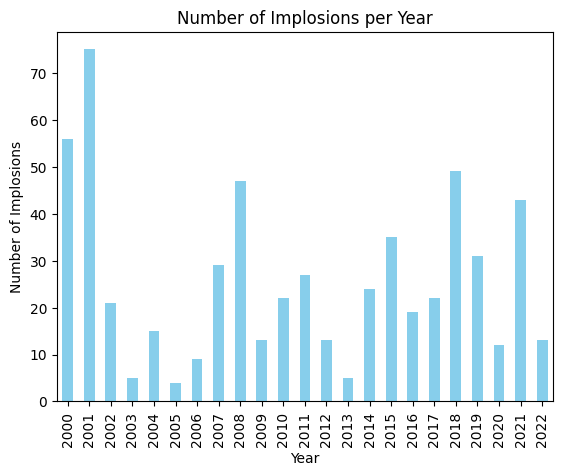

In [14]:
def plot_prices(imp_df, pic_name):
    adj = get_fund_data(imp_df)
    imp_df = imp_df.toPandas()
    adj_pd = adj.toPandas()
    adj_pd['date'] = pd.to_datetime(adj_pd['date'])
    list_to_plot = sorted(adj_pd['fsym_id'].unique().tolist())
    
    columns = 8
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = adj_pd[adj_pd['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].rolling(52).mean(), label=f'{t} (52-week)')
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].rolling(5).mean(), label=f'{t} (5-week)')
        
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].ewm(span=7, adjust=False).mean())
        # axs[i].plot(temp_df['date'], temp_df['adj_price'].ewm(span=52, adjust=False).mean())
        
        imp_start_date = imp_df.loc[imp_df['fsym_id']==t, 'Implosion_Start_Date'].iloc[0]
        imp_end_date = imp_df.loc[imp_df['fsym_id']==t, 'Implosion_End_Date'].iloc[0]
        if imp_start_date is not None:
            # filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            # vol = filtered_temp_df['split_adj_price'].std()
            imp_start_date = pd.to_datetime(imp_start_date)
            imp_end_date = pd.to_datetime(imp_end_date)
            #filtered_temp_df = temp_df[(temp_df['p_date'] >= imp_start_date) & (temp_df['p_date'] <= imp_end_date)]
            #print(filtered_temp_df.head())
            axs[i].axvspan(imp_start_date, imp_end_date, alpha=0.5, color='blue')
        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig(pic_name)
    
    
def sample_plots():
    imp_df = pd.read_csv('imploded_stocks_dd.csv', index_col=False)
    imps_only = imp_df.loc[imp_df['Implosion_Start_Date'].notnull()]
    imps_only = spark.createDataFrame(imps_only.tail(24))
    plot_prices(imps_only, 'sample_implosions_dd.png')
    
def sample_plots_2022():
    imp_df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imps_only = imp_df.loc[imp_df['Implosion_Start_Date'].notnull()]
    imps_only['Implosion_Start_Date'] = pd.to_datetime(imps_only['Implosion_Start_Date'])
    imps_only['year'] = imps_only['Implosion_Start_Date'].dt.year
    imps_only = imps_only[imps_only['year']==2022]
    imps_only = spark.createDataFrame(imps_only.tail(40))
    plot_prices(imps_only, 'sample_implosions_2022.png')
    compare_with_yahoo(imps_only)

def number_imploded():
    imp_df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imps_only = imp_df.loc[imp_df['Implosion_Start_Date'].notnull()]
    print("Number imploded: ", len(imps_only))
    
def visualize_implosions():
    df = pd.read_csv('imploded_stocks_dd.csv', index_col=False)

    # Check for missing values in 'Implosion_Start_Date' column
    if df['Implosion_Start_Date'].isnull().any():
        # Drop rows with missing values in 'Implosion_Start_Date'
        df = df.dropna(subset=['Implosion_Start_Date'])
    
    # Convert 'Implosion_Start_Date' to datetime and extract only the year
    df['Implosion_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.year

    implosions_per_year = df.groupby('Implosion_Date').size()

    implosions_per_year.plot(kind='bar', color='skyblue')

    plt.title('Number of Implosions per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Implosions')
    plt.savefig('Implosions_per_year.png')
    plt.show()
    


def compare_with_yahoo(df):
    df.createOrReplaceTempView('temp')
    q = """SELECT str.ticker_region, t.fsym_id FROM temp t LEFT JOIN sym_ticker_region str ON str.fsym_id = t.fsym_id"""
    ticker_df = spark.sql(q)
    ticker_df = ticker_df.toPandas()
    list_to_plot = sorted(ticker_df['ticker_region'].tolist())
    
    columns = 3
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(15, 5*num_rows))
    axs = axs.flatten()
    i=0
    for t in list_to_plot:
        stock_data = yf.download(t[:-3], start='2001-01-01', end='2023-11-02')
        if not stock_data.empty:
            stock_data = stock_data['Adj Close'].resample('W').last()
            axs[i].plot(stock_data.index, stock_data, label=ticker_df.loc[ticker_df['ticker_region'] == t, 'fsym_id'])
            axs[i].legend()
        i+=1
            
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    plt.tight_layout()
    plt.savefig('yahoo_stocks.png')
    

# sample_plots()
visualize_implosions()
# sample_plots_2022()

In [36]:
def stock_start_analysis():
    stocks_df = pd.read_csv('imploded_stocks_price.csv')
    stocks_df['Implosion_Start_Date'] = pd.to_datetime(stocks_df['Implosion_Start_Date'])
    stocks_df['Implosion_End_Date'] = pd.to_datetime(stocks_df['Implosion_End_Date'])
    stocks_df = spark.createDataFrame(stocks_df)
    stocks_df.createOrReplaceTempView("temp_table")
    query = f"""SELECT t.fsym_id, c.p_first_date FROM temp_table t LEFT JOIN fp_sec_coverage c ON c.fsym_id=t.fsym_id
                    ORDER BY t.fsym_id
            """
    start_df = spark.sql(query)
    start_df = start_df.toPandas()
    start_df['p_first_date'] = pd.to_datetime(start_df['p_first_date'])
    start_df['Year'] = start_df['p_first_date'].dt.year
    print(start_df.head())
    starts_per_year = start_df.groupby('Year').size()
    print(starts_per_year)
    
    plt.figure(figsize=(10,5))
    starts_per_year.plot(kind='bar')
    plt.title('Earliest dates of stocks')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')

    plt.show()
    


    
    
    
# stock_start_analysis()  
# compare_methods()
# compare_lengths()
#create_implosion_price_plots()

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Number with no industry label:  0


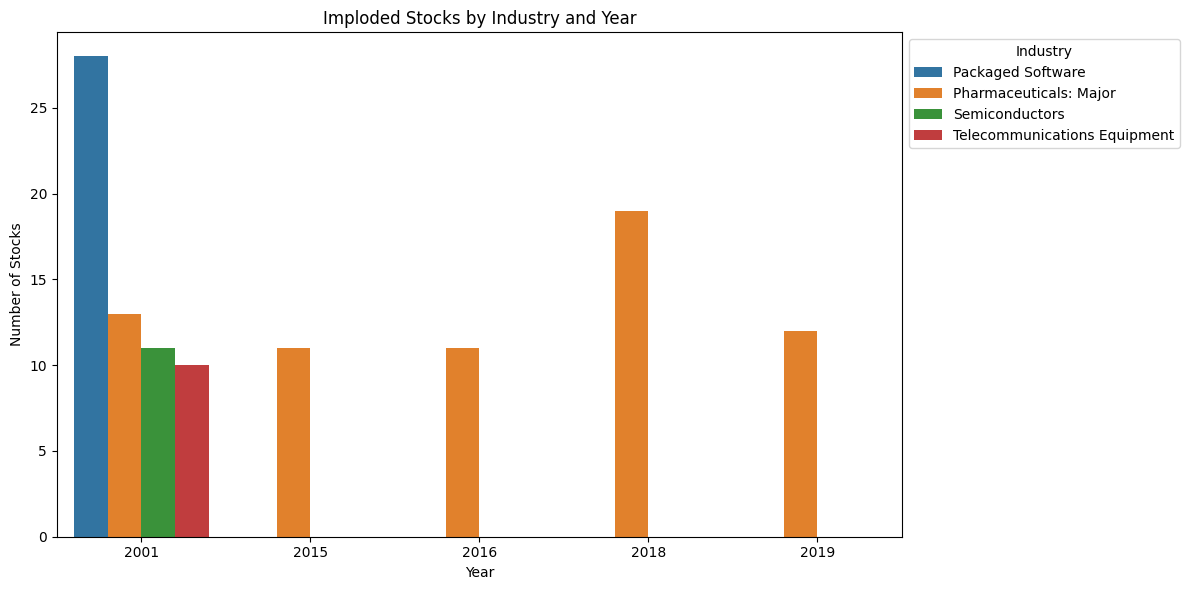

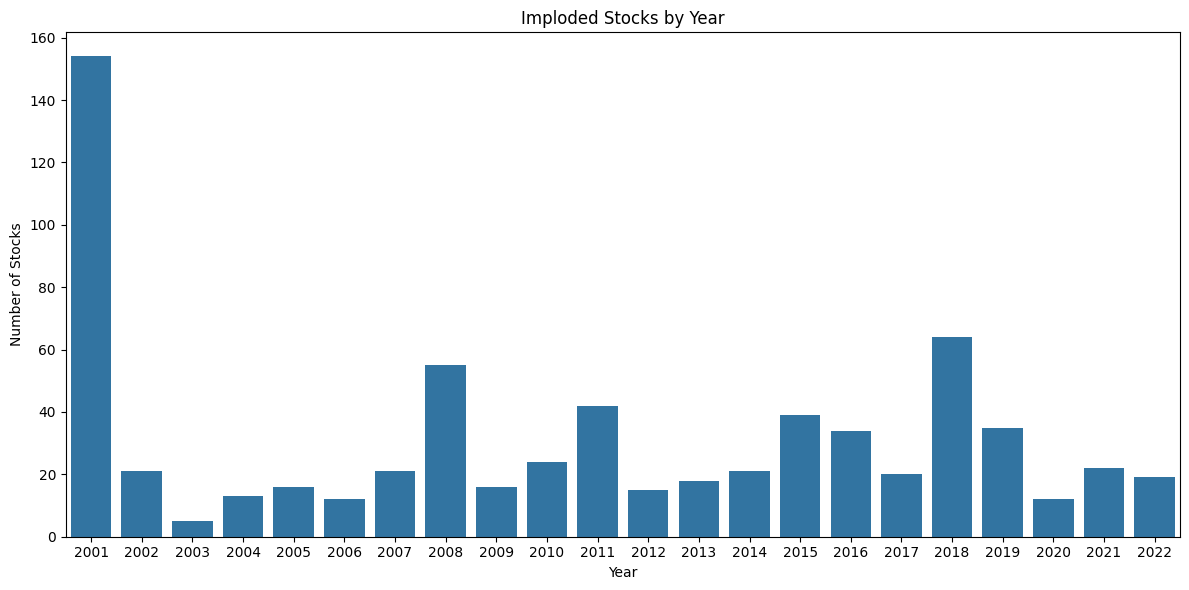

In [11]:
import calendar

def industry_analysis_all():
    #stock_df = get_all_stocks_df()
    stock_df = pd.read_csv(f'data/imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = """SELECT t.fsym_id, t.Implosion_Start_Date, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    ind_df = ind_df.toPandas()
    ind_df['Implosion_Date'] = pd.to_datetime(ind_df['Implosion_Start_Date'])
    ind_df['year'] = ind_df['Implosion_Date'].dt.year
    null_count = ind_df['factset_industry_desc'].isnull().sum()
    print("Number with no industry label: ", null_count)
    
    ind_df_grp = ind_df.groupby(['year', 'factset_industry_desc']).size().reset_index(name='count')

    ind_df_grp = ind_df_grp[ind_df_grp['count'] >= 10]

    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='count', hue='factset_industry_desc', data=ind_df_grp)

    plt.title('Imploded Stocks by Industry and Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')
    plt.legend(title='Industry', bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('industry_plots_price.png')
    
    ind_df_year = ind_df.groupby('year').size().reset_index(name='count')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='year', y='count', data=ind_df_year)

    plt.title('Imploded Stocks by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks')
    plt.tight_layout()
    plt.savefig('Implosions_per_year_price.png')
    plt.show()

def industry_plots(industry):
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    print(len(stock_df))
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = f"""SELECT t.fsym_id, t.Implosion_Start_Date, t.Implosion_End_Date, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE e.factset_industry_desc = "{industry}"
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    plot_prices(ind_df.limit(100), f"{industry}_imploded.png")
    
    
def examine_year():
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_df.createOrReplaceTempView("temp_table")
    q2 = """SELECT t.fsym_id, t.Implosion_Start_Date, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    ORDER BY t.fsym_id
    """
    ind_df = spark.sql(q2)
    ind_df = ind_df.toPandas()
    ind_df['Implosion_Start_Date'] = pd.to_datetime(ind_df['Implosion_Start_Date'])
    ind_df['year'] = ind_df['Implosion_Start_Date'].dt.year
    ind_df_year = ind_df[ind_df['year'] == 2022]
    ind_df_year['month'] = ind_df_year['Implosion_Start_Date'].dt.month
    ind_df_year['month_name'] = ind_df_year['Implosion_Start_Date'].dt.month_name()

    # Specify the order of months
    month_order = list(calendar.month_name)[1:]  # List of month names excluding the empty string

    ind_df_grp = ind_df_year.groupby(['month_name']).size().reindex(month_order, fill_value=0).reset_index(name='count')
    print(ind_df_grp.head())

    plt.figure(figsize=(12, 6))
    sns.barplot(x='month_name', y='count', data=ind_df_grp, color='skyblue', order=month_order)

    plt.title('Imploded Stocks in 2022')
    plt.xlabel('Month')
    plt.ylabel('Number of Stocks')
    plt.show()

def mkt_val_per_year():
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_series = get_fund_data(stock_df)
    stock_series.show()
    stock_series = stock_series.join(stock_df.select("fsym_id", "Implosion_Start_Date"), "fsym_id", "inner")
    stock_series = stock_series.withColumn('year',F.year('Implosion_Start_Date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date'))
    stock_series = stock_series.withColumn('Max_Market_Value', F.max('Market_Value').over(window_spec))
    
    
    filtered_df = stock_series.filter(F.col('Max_Market_Value') < 2e9)

    grouped_df = filtered_df.groupBy('year').agg(F.countDistinct('fsym_id').alias('num_stocks'))

    pandas_df = grouped_df.toPandas()

    plt.bar(pandas_df['year'], pandas_df['num_stocks'])
    plt.xlabel('Year')
    plt.ylabel('Number of Stocks with Market Val < $2bn')
    plt.title('Number of Stocks with Market Val < $2bn')
    plt.show()

industry_analysis_all()
# examine_year()
# mkt_val_per_year()
# industry_plots('Pharmaceuticals: Major')

In [35]:
def plot_stock_price(ticker):
    # Fetching data from Yahoo Finance
    print(ticker[:-3])
    stock_data = yf.download(ticker[:-3], start='2001-01-01', end='2023-11-02')
    if not stock_data.empty:
        stock_data = stock_data['Adj Close'].resample('W').last()
        print(stock_data.head())
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(stock_data.index, stock_data)
        plt.title(f'{ticker} Stock Price Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()

def compare_prices():
    unique_values = ['AAPL-US', 'ABIO-US', 'PTEK-US', 'AIG-US']
    for u in unique_values:
        q = f"""SELECT str.fsym_id FROM sym_ticker_region str WHERE str.ticker_region = "{u}" """
        qdf = spark.sql(q)
        price_df = get_fund_data(qdf)
        price_df.show()
        #id_t = yf_ticker_df.select('ticker_region').first()[0]
        stock_data = price_df.select('p_date', 'adj_price').orderBy('p_date').toPandas()

        # Convert 'p_date' to datetime if needed
        stock_data['p_date'] = pd.to_datetime(stock_data['p_date'])
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(stock_data['p_date'], stock_data['adj_price'])
        plt.title('Stock Price Over Time')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()
        
        plot_stock_price(u)
        
def is_imploded(ticker):
    q = f"""SELECT str.fsym_id FROM sym_ticker_region str WHERE str.ticker_region = "{ticker}" """
    qdf = spark.sql(q).toPandas()
    fsym_id = qdf['fsym_id'].iloc[0]
    imp_df = pd.read_csv('imploded_stocks_price.csv')
    imp_df = imp_df[imp_df['Implosion_Start_Date'].notnull()]
    if fsym_id in imp_df['fsym_id']:
        print("yes")
    else:
        print("no")

# is_imploded('MITO-US')
    

# tickers_feats = spark.createDataFrame(df[:5])
# sp_df = get_fund_data(tickers_feats)
#compare_prices()
#plot_stock_price('BHZYXG-R')

no


In [12]:
def zscore_plots():
    stock_df = pd.read_csv('imploded_stocks_price.csv')
    stock_df = stock_df.loc[stock_df['Implosion_Start_Date'].notnull()]
    stock_df = spark.createDataFrame(stock_df)
    stock_series = get_fund_data(stock_df)
    stock_series = stock_series.join(stock_df.select("fsym_id", "Implosion_Start_Date"), "fsym_id", "inner")
    stock_series.createOrReplaceTempView('temp')
    q =f"""SELECT t.fsym_id, t.date, t.Implosion_Start_Date, t.adj_price, a.FF_ZSCORE FROM temp t LEFT JOIN FF_ADVANCED_DER_QF a ON YEAR(a.date) = YEAR(t.date)
                AND MONTH(t.date) = MONTH(a.date) AND t.fsym_id = a.fsym_id"""
    z_df = spark.sql(q)
    z_df = z_df.orderBy('fsym_id', 'date')

    
#     # Convert 'p_date' to datetime if needed
    z_df = z_df.toPandas()
    z_df['date'] = pd.to_datetime(z_df['date'])
    z_df['FF_ZSCORE'] = z_df['FF_ZSCORE'].fillna(method='ffill')
    for fsym_id, group_df in z_df.groupby('fsym_id'):
        # Plotting
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))

        # Plotting the first graph
        axs[0].plot(group_df['date'], group_df['adj_price'])
        axs[0].set_title('Stock Price Over Time')
        axs[0].set_xlabel('Date')
        axs[0].set_ylabel('Price')
        axs[0].grid(True)

        # Plotting the second graph
        axs[1].plot(group_df['date'], group_df['FF_ZSCORE'])
        axs[1].set_title('Z-Score Over Time')
        axs[1].set_xlabel('Date')
        axs[1].set_ylabel('Z-Score')
        axs[1].grid(True)

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()
    
# zscore_plots()

In [13]:
# spark.stop()

In [14]:
#idk where to put this back up code:
#     adj = adj.withColumn("temp_cum_split_factor", when(adj.p_date==adj.p_split_date, lit(adj.p_split_factor)).otherwise(lit(1.0)))
#     adj = adj.withColumn("div_split_factor", lit(0.0)) # placeholders
#     adj = adj.withColumn("cum_split_factor", lit(0.0)) # placeholders

#     window_spec = Window.partitionBy('fsym_id').orderBy(F.desc('p_date'))

#     # Calculate cumulative split factor and dividend split factor
#     #adj = adj.withColumn('split_temp_i', F.row_number().over(window_spec) - 1)
#     adj = adj.withColumn('cum_split_factor_no_lag', 
#                         F.exp(F.sum(F.log('temp_cum_split_factor')).over(window_spec)))
#     adj = adj.withColumn('div_split_factor', 
#                         F.exp(F.sum(F.log('temp_cum_split_factor')).over(window_spec)))
#     adj = adj.withColumn('div_split_factor', 
#                         F.when(F.row_number().over(window_spec) == 1, 1.0)
#                         .otherwise('div_split_factor'))
#     adj = adj.withColumn('cum_split_factor', 
#                         F.when(F.row_number().over(window_spec) == 1, 1.0)
#                         .otherwise(F.lag('cum_split_factor_no_lag', default=1.0).over(window_spec)))
    
#     adj = adj.withColumn('split_adj_price', adj.p_price * adj.cum_split_factor)
#     adj = adj.withColumn('split_adj_div', adj.p_divs_pd * adj.cum_split_factor)
    
#     adj = adj.withColumn("div_factor", when(((adj.p_date == adj.p_divs_exdate) & (adj.p_divs_s_pd == 1)), lit(adj.split_adj_div)).otherwise(lit(0.0)))
    
#     adj = adj.withColumn("temp_cum_spin_factor", when((adj.split_adj_price - adj.div_factor <= 0), lit(1.0)).otherwise(lit((adj.split_adj_price - adj.div_factor)/adj.split_adj_price)))
    
#     adj = adj.withColumn("cum_spin_factor", lit(0.0))
    
#     adj = adj.withColumn('cum_spin_factor', 
#                         F.exp(F.sum(F.log('temp_cum_spin_factor')).over(window_spec)))
    
#     adj = adj.withColumn('cum_spin_factor', 
#                         F.when(F.row_number().over(window_spec) == 1, 1.0)
#                         .otherwise(F.lag('cum_spin_factor', default=1.0).over(window_spec)))
    
#     adj = adj.withColumn("adj_price", adj.split_adj_price * adj.cum_spin_factor)